In [1]:
!pip uninstall -y -q yellowbrick

!pip install -q tifffile # contains tools to operate tiff-files
!pip install -q folium==0.2.1
!pip install -q imgaug==0.2.5
!pip install -q opencv-python==3.4.5.20
!pip install opencv-python-headless==4.1.2.30
!pip install -q wget
!pip install -q memory_profiler
!pip install -q fpdf
!pip install -q pycocotools
!pip install -q fastremap
!pip install -q natsort

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.8/21.8 MB 30.7 MB/s eta 0:00:00
  Attempting uninstall: opencv-python-headless
    Found existing installation: opencv-python-headless 4.5.4.60
    Uninstalling opencv-python-headless-4.5.4.60:
      Successfully uninstalled opencv-python-headless-4.5.4.60


In [2]:
import sys
sys.path.append('../input/sartorius-instance-segmentation/cellpose/cellpose')

In [3]:
import numpy as np
import pandas as pd
from tqdm import tqdm
import matplotlib.pyplot as plt
import os
import tifffile
import imageio
import glob
import shutil
from cellpose import models, io, plot
import glob
import shutil
import imgaug.augmenters as iaa
import imgaug as ia
import time
import cv2

In [4]:
# Original Image Dimensions
HEIGHT = 520
WIDTH = 704
SHAPE = (HEIGHT, WIDTH)

In [5]:
def rles_to_mask(encs, shape=SHAPE):
    """
    Decodes a rle.

    Args:
        encs (list of str): Rles for each class.
        shape (tuple [2]): Mask size.

    Returns:
        np array [shape]: Mask.
    """
    img = np.zeros(shape[0] * shape[1], dtype=np.uint)
    if type(encs)==float:
        return img
    for m, enc in enumerate(encs):
        if isinstance(enc, np.float) and np.isnan(enc):
            continue
        enc_split = enc.split()
        for i in range(len(enc_split) // 2):
            start = int(enc_split[2 * i]) - 1
            length = int(enc_split[2 * i + 1])
            img[start: start + length] = 1 + m
    return img.reshape(shape)

## <font color='gold'/> **Prepare data**

In [6]:
orig_train_dataset_folder = '../input/sartorius-cellpose-dataset/train'
orig_val_dataset_folder = '../input/sartorius-cellpose-dataset/val'

In [7]:
!mkdir './cellpose_dataset_train'
!mkdir './cellpose_dataset_val'
!mkdir './models'

In [8]:
for f in glob.glob(os.path.join(orig_train_dataset_folder, '*.tif')):
    if 'flows' not in f:
        shutil.copy(f, os.path.join('./cellpose_dataset_train', f.split('/')[-1]))

In [9]:
for f in glob.glob(os.path.join(orig_val_dataset_folder, '*.tif')):
    if 'flows' not in f:
        shutil.copy(f, os.path.join('./cellpose_dataset_val', f.split('/')[-1]))

In [10]:
train_folder = './cellpose_dataset_train'
test_folder = './cellpose_dataset_val'

In [11]:
!ls {train_folder} | wc -l
!ls {test_folder} | wc -l

970
242


In [12]:
train_img_files = np.sort(glob.glob(os.path.join('cellpose_dataset_train', '*img.tif')))
train_mask_files = np.sort(glob.glob(os.path.join('cellpose_dataset_train', '*masks.tif')))

val_img_files = np.sort(glob.glob(os.path.join('cellpose_dataset_val', '*img.tif')))
val_mask_files = np.sort(glob.glob(os.path.join('cellpose_dataset_val', "*masks.tif")))

assert (len(train_img_files ) == len(train_mask_files)) and (len(val_img_files) == len(val_mask_files))

train_imgs = [tifffile.imread(img_file) for img_file in tqdm(train_img_files)]
train_masks = [tifffile.imread(flows_file) for flows_file in tqdm(train_mask_files)]

val_imgs = [tifffile.imread(img_file) for img_file in tqdm(val_img_files)]
val_masks = [tifffile.imread(flows_file) for flows_file in tqdm(val_mask_files)]

100%|██████████| 121/121 [00:00<00:00, 1518.54it/s]


## <font color='gold'/> **Train**

In [13]:
from math import sqrt

In [14]:
init_lr = 0.001
first_100_lr = np.array([init_lr * sqrt(0.1)] * 100)
mid_100_lr = np.array([first_100_lr[0] * sqrt(0.1)] * 100)
last_100_lr = np.array([mid_100_lr[0] * sqrt(0.1)] * 100)

lrs = np.concatenate([first_100_lr, mid_100_lr, last_100_lr])

In [15]:
cp_model_path = '../input/sartorius-weight/cellpose_250622_concat_epoch_500'
#model_to_load = 'cyto' ## cyto, cyto2, nuclei
number_of_epochs = 300  
batch_size = 8
Training_channel = 0 # For grayscale
Second_training_channel= 0 
#learning_rate = 0.001

In [16]:
from cellpose.io import logger_setup
logger, log_file = logger_setup()

cp_model = models.CellposeModel(gpu=True, pretrained_model=cp_model_path, nchan=2, concatenation=True)

start_time = time.time()

model_path, epochs, loss_vls, val_loss_vls = cp_model.train(train_data=train_imgs, train_labels=train_masks,
                            test_data=val_imgs, test_labels=val_masks,
                            channels=[0, 0], save_path='./models', save_every=1, min_train_masks=5,
                            learning_rate=lrs, n_epochs=number_of_epochs,
                            model_name='cellpose_260622_concat_epoch_800')

end_time = time.time()

creating new log file


100%|██████████| 121/121 [00:12<00:00,  9.83it/s]


In [17]:
training_time = (end_time - start_time) / 3600

print('Train {} epochs took {}'.format(number_of_epochs, training_time))

Train 300 epochs took 1.0589249967866474


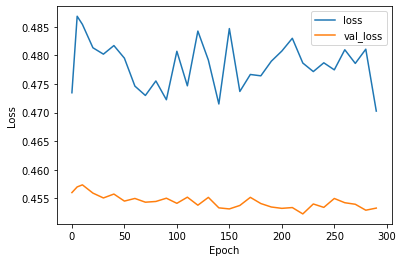

In [18]:
fig = plt.figure(figsize=(6, 4))

plt.plot(epochs, loss_vls)
plt.plot(epochs, val_loss_vls)
plt.legend(['loss', 'val_loss'])

plt.xlabel('Epoch')
plt.ylabel('Loss')

plt.show()

In [19]:
print('Loss: ', loss_vls[-1])
print('Val loss: ', val_loss_vls[-1])

Loss:  0.4702684104688897
Val loss:  0.4533026001670144


In [20]:
model_path

'./models/models/cellpose_260622_concat_epoch_800'